<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-02-27 18:45:05--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.09s   

2021-02-27 18:45:06 (262 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

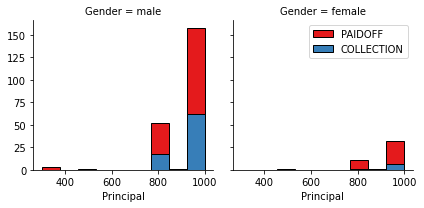

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

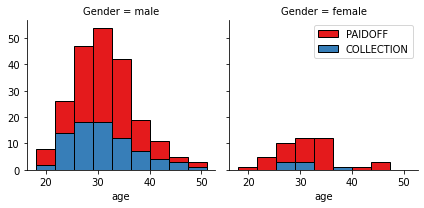

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

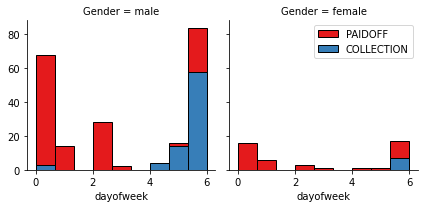

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?

In [18]:
#Make loan status numerical, but first save its values on y_classes (both will be needed bellow)
y_class = df['loan_status'].values
print(y_class[0:5])

df_temp = pd.read_csv('loan_train.csv')
df_temp.replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
print(df_temp.head())
y = df_temp['loan_status'].values
print(y[0:5])

#print(y_class[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
   Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms effective_date  \
0           0             0            1       1000     30       9/8/2016   
1           2             2            1       1000     30       9/8/2016   
2           3             3            1       1000     15       9/8/2016   
3           4             4            1       1000     30       9/9/2016   
4           6             6            1       1000     30       9/9/2016   

    due_date  age             education  Gender  
0  10/7/2016   45  High School or Below    male  
1  10/7/2016   33              Bechalor  female  
2  9/22/2016   27               college    male  
3  10/8/2016   28               college  female  
4  10/8/2016   29               college    male  
[1 1 1 1 1]


## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your loan_train.csv into train and test to find the best __k__.

In [20]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


Mean accuracy values vector:  [0.67142857 0.65714286 0.71428571 0.68571429 0.75714286 0.71428571
 0.78571429 0.75714286 0.75714286]


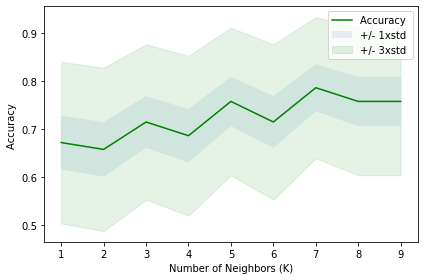

The best accuracy was with 0.7857142857142857 with k =  7


In [21]:
# Find best k for KNN Classification

# Import libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Calculate the accuracy of KNN for different Ks.
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for k in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[k-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[k-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print ('Mean accuracy values vector: ', mean_acc)

# Plot model accuracy for Different number of Neighbors
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# Print best accuracy
print( "The best accuracy was with", mean_acc.max(), "with k = ", mean_acc.argmax()+1) 

In [22]:
# KNN Classification - Training with the whole training set and with best k that was found
k = 7

#Train Model 
neigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)
neigh

KNeighborsClassifier(n_neighbors=7)

# Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Model the tree
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [24]:
# Fit the Testing data into the tree
loanTree.fit(X,y)
#print(y_class[0:5])
#loanTree.fit(X,y_class)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

Solving environment: done

# All requested packages already installed.



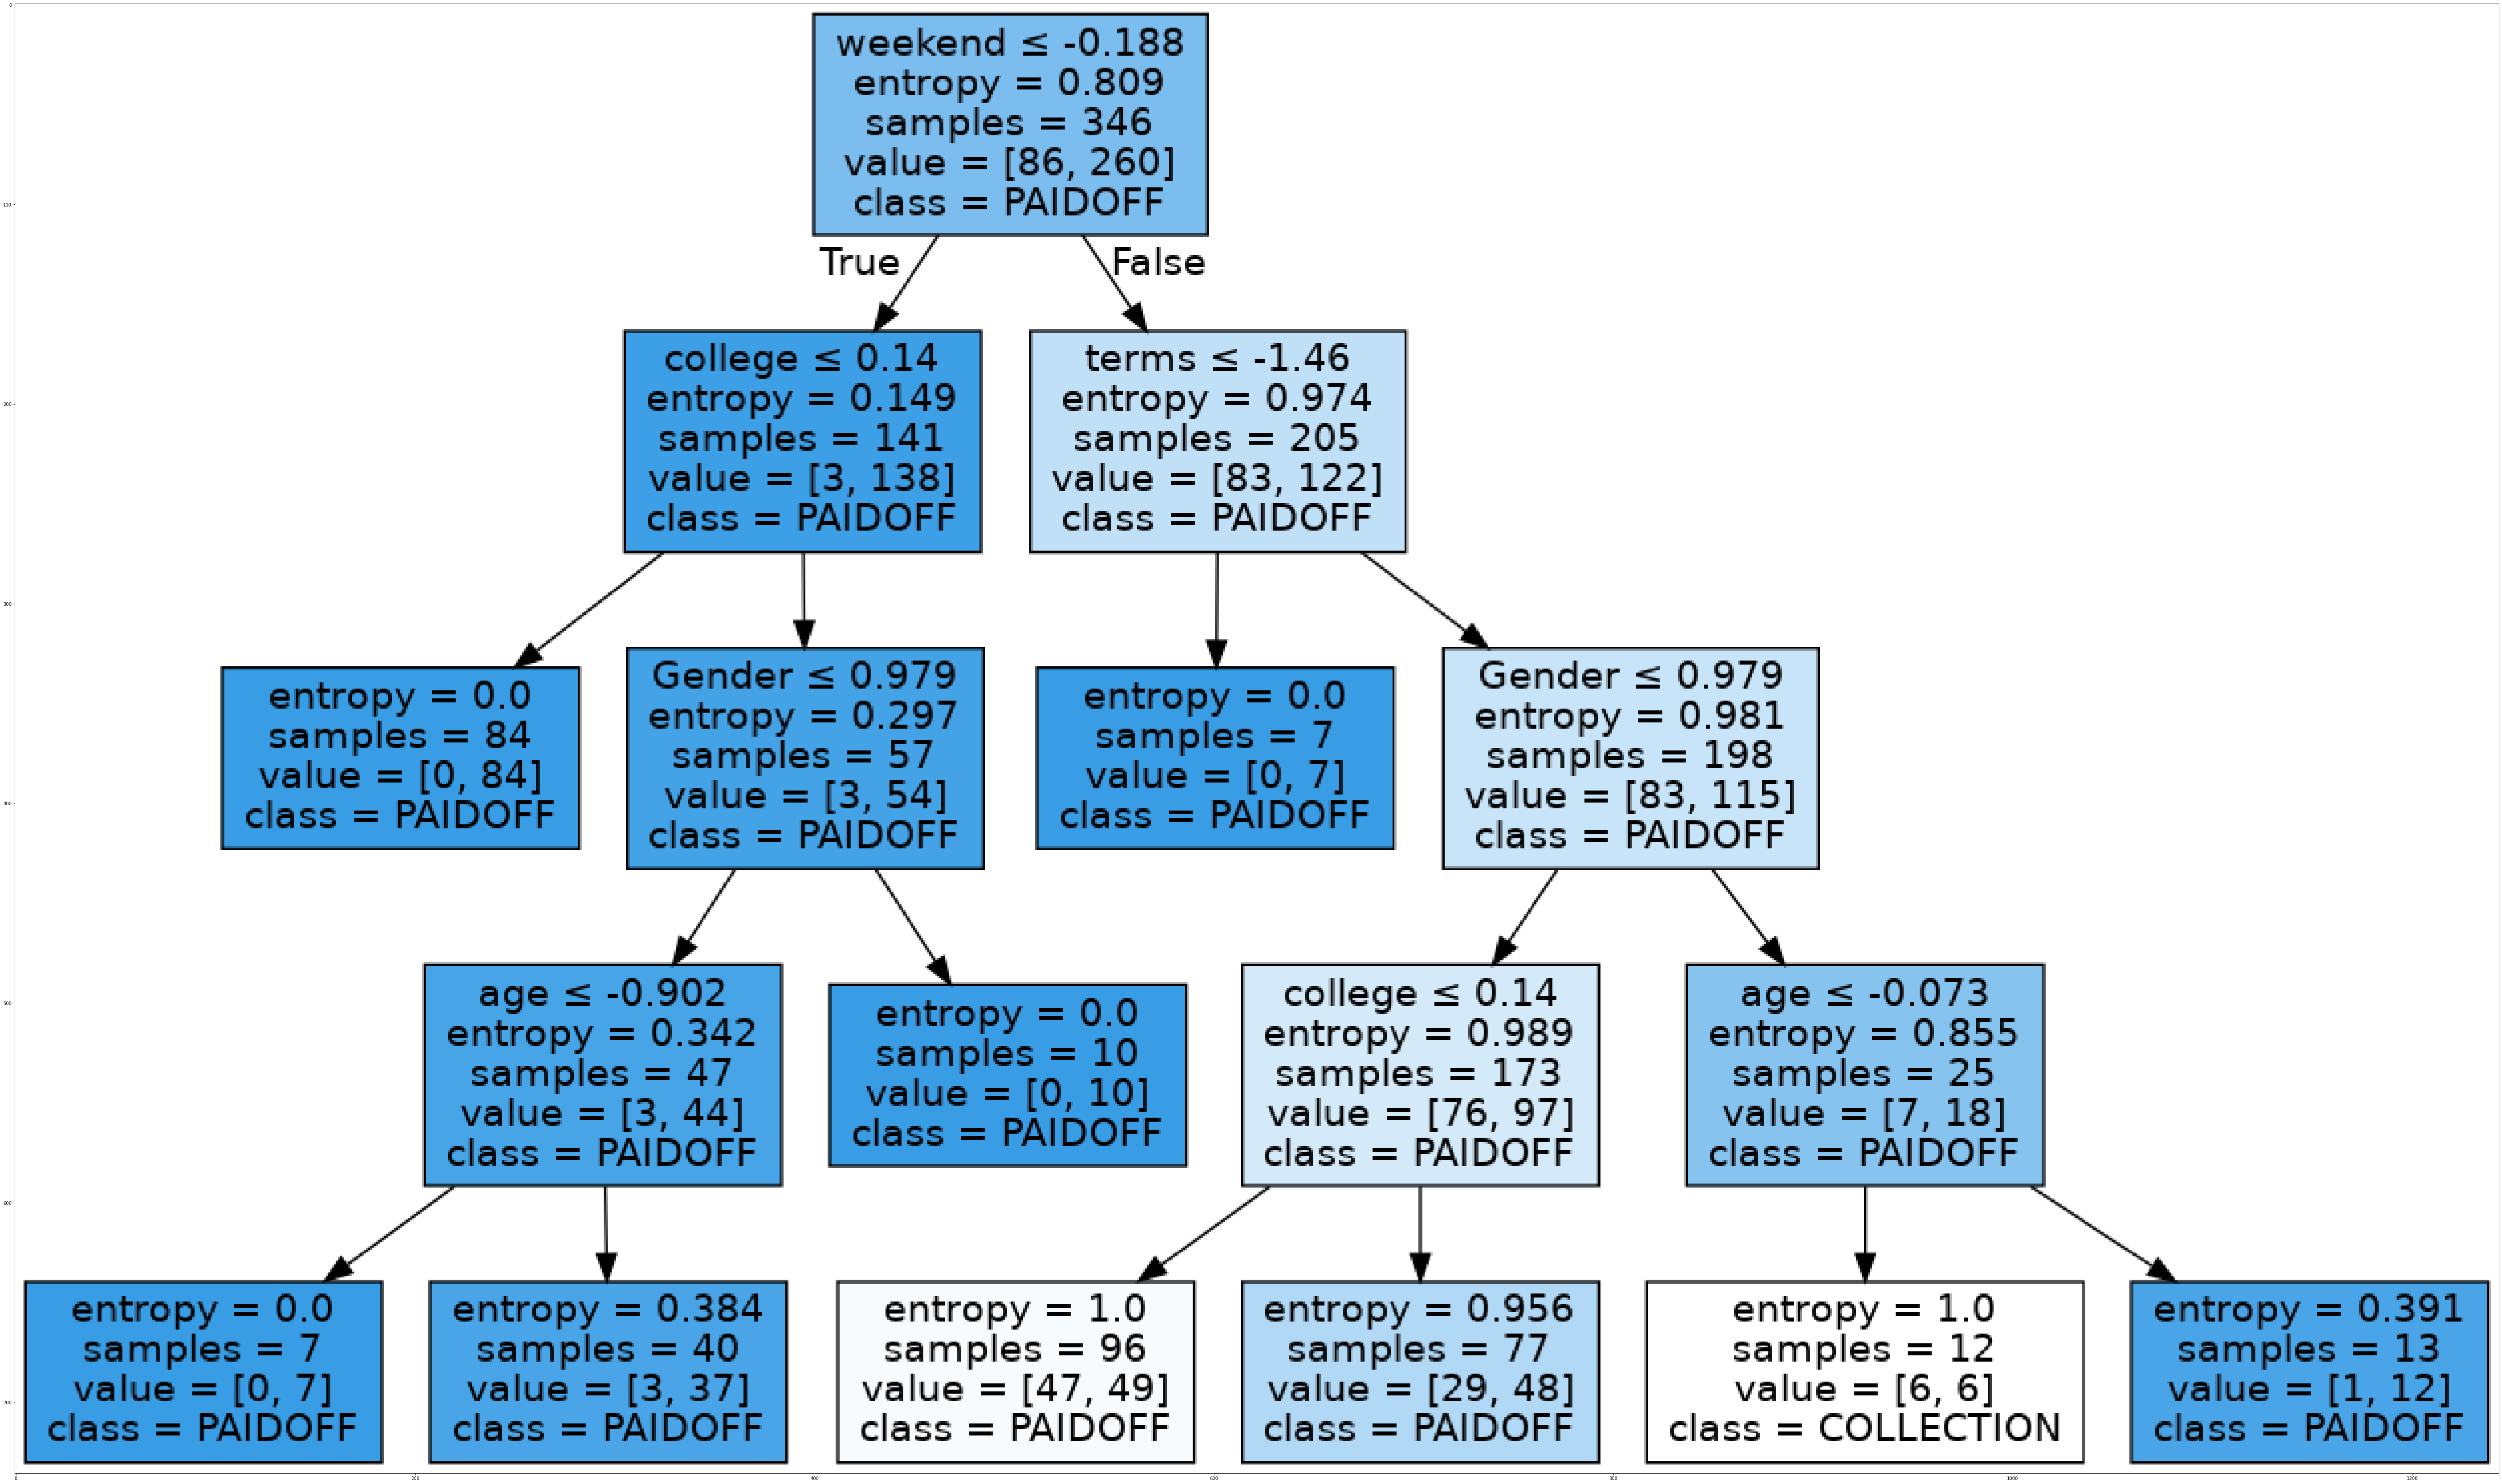

In [25]:
# Visualise the Decision Tree
!conda install -c conda-forge pydotplus -y
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns[0:8]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_class), filled=True,  special_characters=True,rotate=False) 
#out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y), filled=True,  special_characters=True,rotate=False) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [26]:
# Model SVM with Scikit-learn - Kernel = RBF
from sklearn import svm
loanSvmRbf = svm.SVC(kernel='rbf')
loanSvmRbf.fit(X, y) 

SVC()

In [27]:
# Model SVM with Scikit-learn - Kernel = Sigmoid
loanSvmSigmoid = svm.SVC(kernel='sigmoid')
loanSvmSigmoid.fit(X, y) 

SVC(kernel='sigmoid')

In [28]:
# Model SVM with Scikit-learn - Kernel = Polynomial
loanSvmPoly = svm.SVC(kernel='poly')
loanSvmPoly.fit(X, y) 

SVC(kernel='poly')

# Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

# Modeling Logistic Regression with Scikit-learn - Solver = ‘liblinear’
loanLRLinear = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)
loanLRLinear

LogisticRegression(C=0.01, solver='liblinear')

In [30]:
# Modeling Logistic Regression with Scikit-learn - Solver = ‘saga’
loanLRSaga = LogisticRegression(C=0.01, solver='saga').fit(X,y)
loanLRSaga

LogisticRegression(C=0.01, solver='saga')

In [31]:
# Modeling Logistic Regression with Scikit-learn - Solver = ‘newton-cg’
loanLRNewton = LogisticRegression(C=0.01, solver='newton-cg').fit(X,y)
loanLRNewton

LogisticRegression(C=0.01, solver='newton-cg')

# Model Evaluation using Test set

In [32]:
#from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [33]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-02-27 18:45:49--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-02-27 18:45:50 (76.9 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [34]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()
print ('Test set:', test_df.shape)

Test set: (54, 10)


In [35]:
# Data pre-processing for the test set
# Convert to date time object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
#test_df.head()

#Convert Categorical features to numerical values
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

#print('Testing dataframe: ', test_df.head())

testFeature = test_df[['Principal','terms','age','Gender','weekend']]
testFeature = pd.concat([testFeature,pd.get_dummies(test_df['education'])], axis=1)
testFeature.drop(['Master or Above'], axis = 1,inplace=True)
#print('testing Features', testFeature.head())

#Feature selection
testX = testFeature
#print('testX = ', testX[0:5])

# Normalize Data
testX = preprocessing.StandardScaler().fit(testX).transform(testX)
#print('testX after Normalization: ', testX[0:5])

# Make loan status numerical, but first save its values on y_classes (both will be needed bellow)

test_df['loan_status_class'] = test_df['loan_status'].values
#print(test_df.head())
print ('Test set 1:', test_df.shape)

test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
print ('Test set 2:', test_df.shape)
#print(test_df.head())
testy = test_df['loan_status'].values
print ('loan_status:', test_df['loan_status'].shape)
print ('Test y:', testy.shape)
print(testy)
testy_class = test_df['loan_status_class'].values
print(testy_class)

Test set 1: (54, 13)
Test set 2: (54, 13)
loan_status: (54,)
Test y: (54,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'COLLECTION'
 'COLLECTION' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'COLLECTION'
 'COLLECTION' 'COLLECTION' 'COLLECTION']


In [36]:
# For each Classification method, generate predictions using the test set (testX)

# K Nearest Neighbor(KNN)
yhat_knn = neigh.predict(testX)
#print('yhat_knn = ', yhat_knn[0:5])

# Decision Tree
yhat_tree = loanTree.predict(testX)
#print('yhat_tree = ', yhat_tree[0:5])

# Support Vector Machine
#Kernel = RBF
yhat_svmRbf = loanSvmRbf.predict(testX)
#Kernel = Sigmoid
yhat_svmSigmoid = loanSvmSigmoid.predict(testX)
#Kernel = Polynomial
yhat_svmPoly = loanSvmPoly.predict(testX)

# Logistic Regression
# Solver = ‘liblinear’
yhat_lrLinear = loanLRLinear.predict(testX)
yhat_lrLinear_prob = loanLRLinear.predict_proba(testX)
# Solver = ‘saga’
yhat_lrSaga = loanLRSaga.predict(testX)
yhat_lrSaga_prob = loanLRSaga.predict_proba(testX)
# Solver = ‘newton-cg’
yhat_lrNewton = loanLRNewton.predict(testX)
yhat_lrNewton_prob = loanLRNewton.predict_proba(testX)

In [37]:
# Evaluate for each classification method
# K Nearest Neighbor(KNN)
print("KNN for k = ", k, "Jaccard score: ", jaccard_score(testy, yhat_knn))
print("KNN for k = ", k, "F1-score: ", f1_score(testy, yhat_knn)) 

# Decision Tree
print("Decision Tree Jaccard score: ", jaccard_score(testy, yhat_tree))
print("Decision Tree F1-score: ", f1_score(testy, yhat_tree))

# Support Vector Machine
#Kernel = RBF
print("SVM with Kernel = RBF Jaccard score: ", jaccard_score(testy, yhat_svmRbf))
print("SVM with Kernel = RBF F1-score: ", f1_score(testy, yhat_svmRbf))
#Kernel = Sigmoid
print("SVM with Kernel = Sigmoid Jaccard score: ", jaccard_score(testy, yhat_svmSigmoid))
print("SVM with Kernel = Sigmoid F1-score: ", f1_score(testy, yhat_svmSigmoid))
#Kernel = Polynomial
print("SVM with Kernel = Polynomial Jaccard score: ", jaccard_score(testy, yhat_svmPoly))
print("SVM with Kernel = Polynomial F1-score: ", f1_score(testy, yhat_svmPoly))

# Logistic Regression
# Solver = ‘liblinear’
print("LR with Solver = ‘liblinear’ Jaccard score: ", jaccard_score(testy, yhat_lrLinear))
print("LR with Solver = ‘liblinear’ F1-score: ", f1_score(testy, yhat_lrLinear))
print("LR with Solver = ‘liblinear’ LogLoss: ", log_loss(testy, yhat_lrLinear_prob))
# Solver = ‘saga’
print("LR with Solver = ‘saga’ Jaccard score: ", jaccard_score(testy, yhat_lrSaga))
print("LR with Solver = ‘saga’ F1-score: ", f1_score(testy, yhat_lrSaga))
print("LR with Solver = ‘saga’ LogLoss: ", log_loss(testy, yhat_lrSaga_prob))
# Solver = ‘newton-cg’
print("LR with Solver = ‘newton-cg’ Jaccard score: ", jaccard_score(testy, yhat_lrNewton))
print("LR with Solver = ‘newton-cg’ F1-score: ", f1_score(testy, yhat_lrNewton))
print("LR with Solver = ‘newton-cg’ LogLoss: ", log_loss(testy, yhat_lrNewton_prob))

KNN for k =  7 Jaccard score:  0.7
KNN for k =  7 F1-score:  0.823529411764706
Decision Tree Jaccard score:  0.7647058823529411
Decision Tree F1-score:  0.8666666666666667
SVM with Kernel = RBF Jaccard score:  0.7222222222222222
SVM with Kernel = RBF F1-score:  0.8387096774193549
SVM with Kernel = Sigmoid Jaccard score:  0.6792452830188679
SVM with Kernel = Sigmoid F1-score:  0.8089887640449438
SVM with Kernel = Polynomial Jaccard score:  0.7307692307692307
SVM with Kernel = Polynomial F1-score:  0.8444444444444444
LR with Solver = ‘liblinear’ Jaccard score:  0.7407407407407407
LR with Solver = ‘liblinear’ F1-score:  0.851063829787234
LR with Solver = ‘liblinear’ LogLoss:  0.5566084946309207
LR with Solver = ‘saga’ Jaccard score:  0.7407407407407407
LR with Solver = ‘saga’ F1-score:  0.851063829787234
LR with Solver = ‘saga’ LogLoss:  0.5153688284391975
LR with Solver = ‘newton-cg’ Jaccard score:  0.7407407407407407
LR with Solver = ‘newton-cg’ F1-score:  0.851063829787234
LR with Solv

# Report
You should be able to report the accuracy of the built model using different evaluation metrics. For each algorithm, we report the best observed metric.

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.7       | 0.82        | NA      |
| Decision Tree      | 0.76       | 0.87        | NA      |
| SVM                | 0.73       | 0.84        | NA      |
| LogisticRegression | 0.74       | 0.85        | 0.52       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>